# Assignment 6

### a)

In [2]:
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import scipy.stats as ss
from datetime import datetime
from scipy import stats
#goqhuB-1hafqe-dojvix
import wrds
db = wrds.Connection(wrds_username = 'anita97') 

Loading library list...
Done


In [3]:
#import stocks
stocks = db.raw_sql("select a.permno, a.date, b.exchcd, a.ret, a.shrout, b.shrcd, a.prc \
                  from crsp.msf as a \
                  join crsp.msenames as b \
                  on a.permno = b.permno and b.namedt <= a.date and a.date<=b.nameendt \
                  where b.shrcd between (10) and (11)and a.date >='2000-01-01' and a.date<='2019-12-31'\
                  and b.exchcd between 1 and 2")
stocks.head()

,permno,date,exchcd,ret,shrout,shrcd,prc
0,10001.0,2009-12-31,2.0,0.162621,4361.0,11.0,10.3000
1,10001.0,2010-01-29,2.0,-0.018932,4361.0,11.0,10.0600
2,10001.0,2010-02-26,2.0,-0.000656,4361.0,11.0,10.0084
3,10001.0,2010-03-31,2.0,0.020643,4361.0,11.0,10.1700
4,10001.0,2010-04-30,2.0,0.124385,6070.0,11.0,11.3900


In [4]:
# drop NA and shares with less than 24 observations 
#stocks = stocks.reset_index
stocks = stocks.set_index('permno')
x = stocks.groupby('permno').count()['ret'][lambda x: x>=240]
selected_stocks=list(x.index)
stocks=stocks.loc[selected_stocks]
stocks=stocks.dropna()
num_after = stocks.shape[0]
stocks['prc'] = abs(stocks['prc'])

In [5]:
# import risk free rate
RF = db.raw_sql("select mcaldt as date, tmytm as rf from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='2000-01-01' and mcaldt<='2019-12-31'")
Rf_monthly = np.exp(np.divide(RF.rf, 1200)) -1
Rf = pd.DataFrame([RF.date, Rf_monthly], index=['date', 'rf']).T
Rf.head()

,date,rf
0,2000-01-31,0.00449835
1,2000-02-29,0.00443834
2,2000-03-31,0.00489188
3,2000-04-28,0.00440126
4,2000-05-31,0.00390314


In [6]:
# import rm 
Rm = db.raw_sql("select date, vwretd from crsp.msi where date>='2000-01-01' and date<='2019-12-31'")
Rm = pd.DataFrame([Rm.date, Rm.vwretd.values], index=['date', 'mkt_ret']).T
Rm = Rm.set_index('date')
Rm.head()

,mkt_ret
date,
2000-01-31,-0.0396243
2000-02-29,0.0317784
2000-03-31,0.0535007
2000-04-28,-0.059527
2000-05-31,-0.0388696


### b)

In [7]:
beta_series=[]
for i in selected_stocks:
    current_stock=stocks.loc[i]
    cov=np.cov((current_stock.ret.astype(float)), (Rm.loc[current_stock.date].mkt_ret.astype(float)))
    beta_series.append(cov[0,1]/cov[1,1])


In [8]:
beta = pd.DataFrame(beta_series, index=selected_stocks, columns=["beta"])
beta.head()

,beta
10145.0,1.200190
10294.0,0.758752
10308.0,0.443625
10516.0,0.497710
10517.0,0.642811


In [9]:
pd_decile = pd.DataFrame(pd.qcut(beta.beta,10),index=selected_stocks, columns=["beta"])
pd_decile.head()

,beta
10145.0,"(1.151, 1.296]"
10294.0,"(0.744, 0.882]"
10308.0,"(0.425, 0.607]"
10516.0,"(0.425, 0.607]"
10517.0,"(0.607, 0.744]"


In [10]:
inters = pd.qcut(beta.beta,10).values
inters = list(dict.fromkeys(inters))
print(type(inters))
inters.sort()
print(f"We have {len(inters)} portfolios")

<class 'list'>
We have 10 portfolios


In [11]:
pd_decile.sort_values(by="beta")
pd_decile.reset_index(inplace=True)
group_by_decile = pd_decile.groupby("beta")
 #group_by_decile.head()

In [12]:
avg_returns = []
avg_beta = []
for i in inters:
    stock_index_by_inderval = group_by_decile.get_group(i)["index"]
    temp = stocks.loc[stock_index_by_inderval]
    group_by_date = temp.groupby('date').mean()
    comp = group_by_date.ret
    avg_returns.append(comp.mean())
    avg_beta.append(beta.loc[stock_index_by_inderval].mean())
avg_returns


[0.010578064200653155,
 0.011673588307960777,
 0.011795769574635148,
 0.012387057064423928,
 0.012546739651515667,
 0.011388637649192823,
 0.011605631100893162,
 0.01352149839154229,
 0.012934378870434981,
 0.013057582155231165]

The market has a mean return of 0.005825365536250002 and 
the risk-free portfolio of 0.0013152996576685284.


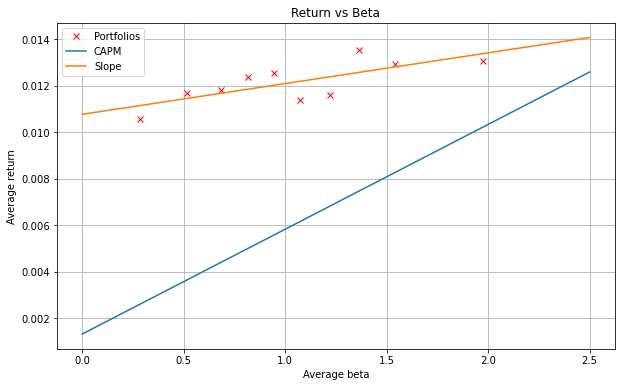

In [13]:
avg_ret_m = Rm.mkt_ret.mean()
avg_rf    = Rf.rf.mean()
print(f"The market has a mean return of {avg_ret_m} and \nthe risk-free portfolio of {avg_rf}.")
slope, intercept, r_value, p_value, std_err = stats.linregress([avg_beta[i][0] for i in range(len(avg_beta))],avg_returns)
plt.figure(figsize=(10,6))
plt.plot(avg_beta, avg_returns, 'rx', label='Portfolios')
plt.plot(np.linspace(0,2.5,100), avg_rf + np.linspace(0,2.5,100)*(avg_ret_m - avg_rf), label='CAPM')
plt.plot(np.linspace(0,2.5,100),np.linspace(0,2.5,100)*slope+intercept,label = 'Slope')
plt.title('Return vs Beta')
plt.xlabel('Average beta')
plt.ylabel('Average return')
plt.grid()
plt.legend(loc='best')
plt.show()

In [14]:
print('Slope coefficient :',slope)

Slope coefficient : 0.001322463948955196


from scipy.stats import t
alpha = 0.05
t_tabel = t.ppf(1 - alpha/2, len(simple_return) - 1)
t_stat = (np.sqrt((len(simple_return)-1)) * average) / standard_deviation
if np.abs(t_stat)>t_tabel:
    print("We reject H0, t-stat :",t_stat)
else:
    print("We can't reject H0 and the mean return is not statiscally different from 0, t-stat :",t_stat)

### c)

In [16]:
idx_L = group_by_decile.get_group(inters[0])["index"]
idx_H = group_by_decile.get_group(inters[-1])["index"]

stock_low_beta = stocks.loc[idx_L]
stock_high_beta = stocks.loc[idx_H]

group_by_date_low = stock_low_beta.groupby('date').mean()
group_by_date_high = stock_high_beta.groupby('date').mean()

simple_return = group_by_date_high.ret - group_by_date_low.ret

average = simple_return.mean()
standard_deviation = simple_return.std()

print('Average return : ',average)
print('Standar deviation : ',standard_deviation)

Average return :  0.0024795179545780087
Standar deviation :  0.09158556279877916


### d)

In [17]:
stocks.insert(5, 'mkt_cap', stocks.prc * stocks.shrout)
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [19]:
stocks.insert(7,'mrk_cap_lag',stocks.groupby('permno')['mkt_cap'].shift(1))
stocks_wavg = stocks.groupby('permno').mean()
stocks_wavg.insert(6,'beta',beta)

ValueError: cannot insert mrk_cap_lag, already exists

In [21]:
stocks_wavg.head()

,exchcd,ret,shrout,shrcd,mkt_cap,prc,beta,mrk_cap_lag
permno,,,,,,,,
10145.0,1.0,0.010356,787067.300000,11.0,5.383612e+07,69.671583,1.200190,5.388216e+07
10294.0,1.0,0.008516,3408.062500,11.0,5.277517e+04,16.600359,0.758752,5.265302e+04
10308.0,2.0,0.010968,11220.216667,11.0,5.958930e+05,50.030000,0.443625,5.926666e+05
10516.0,1.0,0.010984,630102.508333,11.0,1.915516e+07,30.693188,0.497710,1.919784e+07
10517.0,1.0,0.014358,36869.454167,11.0,1.199527e+06,26.750365,0.642811,1.188500e+06


In [15]:
w_avg_returns = []
w_avg_beta = []
for i in inters:
    stock_index_by_inderval = group_by_decile.get_group(i)["index"]
    wtemp = stocks.loc[stock_index_by_inderval]
    wgroup_by_date = wtemp.groupby('date').apply(wavg, 'ret', 'mrk_cap_lag')
    w_avg_returns.append(wgroup_by_date.mean())
    w_avg_beta.append(stocks_wavg.beta.loc[stock_index_by_inderval].mean())

NameError: name 'wavg' is not defined

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(w_avg_beta,w_avg_returns)
plt.figure(figsize=(10,6))
plt.plot(w_avg_beta, w_avg_returns, 'ro', label='Portfolios')
plt.plot(np.linspace(0,2.5,100), avg_rf + np.linspace(0,2.5,100)*(avg_ret_m - avg_rf), label='CAPM')
plt.plot(np.linspace(0,2.5,100),np.linspace(0,2.5,100)*slope+intercept,label = 'Slope')
plt.title('Return vs Beta')
plt.xlabel('Average beta')
plt.ylabel('Average return')
plt.grid()
plt.legend(loc='best')
plt.show()

In [48]:
w_stock_low_beta = stocks.loc[idx_L].groupby('date').apply(wavg,'ret','mrk_cap_lag')
w_stock_high_beta = stocks.loc[idx_H].groupby('date').apply(wavg,'ret','mrk_cap_lag')

w_group_by_date_low = w_stock_low_beta.groupby('date').mean()
w_group_by_date_high = w_stock_high_beta.groupby('date').mean()

w_simple_return = w_group_by_date_high - w_group_by_date_low
w_average = w_simple_return.mean()
w_standard_deviation = w_simple_return.std()

display(w_average)
display(w_standard_deviation)

-0.003075309148491093

0.07981568753132572

In [49]:
print('Slope coefficient :',slope)

Slope coefficient : -0.0016223147191898996


In [50]:
from scipy.stats import t
alpha = 0.05
w_t_stat = (np.sqrt((len(w_simple_return)-1)) * w_average) / w_standard_deviation

if np.abs(w_t_stat)>t_tabel:
    print("We reject H0, t-stat :",t_stat)
else:
    print("We can't reject H0 and the mean return is not statiscally different from 0, t-stat :",t_stat)

We can't reject H0 and the mean return is not statiscally different from 0, t-stat : 0.4969973131749323


### e)

beta_series=[]
for i in selected_stocks:
    current_stock=stocks.loc[i]
    current_stck = pd.DataFrame({'date':current_stock.date,'ret':current_stock.ret})
    current_stck.set_index('date',inplace = True)
    current_stck = pd.merge(current_stck,Rm,left_index = True, right_index = True )
    cov = current_stck.rolling(24).cov
    #import pdb; pdb.set_trace()
    beta_series.append(cov[0,1]/cov[1,1])

### f)

### g)

In [ ]:
dic = {'date':[],'permno':[],'ret':[],'weight':[]}
df =pd.DataFrame(dic)
dic2 = {i:df for i in range(0,10)}

In [ ]:
stocks1 = stocks.copy()
stocks1.reset_index(inplace=True)
list_date = np.sort([date for date in stocks1['date'].values])
list_date = list(set(list_date))

for k in range(1,len(list_date)):
    date = list_date[k]
    date_0 = list_date[k-1]
    df_date_0 = stocks1.loc[stocks1['date'] == date_0] 
    df_date = stocks1.loc[stocks1['date'] == date]
    df_date.set_index('permno',inplace=True)
    df_date_0.set_index('permno',inplace=True)
    inters = pd.qcut(df_date.weight,10).values
    inters = list(dict.fromkeys(inters))
    inters.sort()
    pd_decile = pd.DataFrame(pd.qcut(df_date.weight,10),index=df_date.index, columns=["weight"])
    pd_decile.sort_values(by="weight")
    pd_decile.reset_index(inplace=True)
    group_by_decile = pd_decile.groupby("weight")
    #print(group_by_decile.head(5))
    df_date.drop(columns='weight', inplace = True)
    df_date_0 = df_date_0.weight
    df_date = pd.concat([df_date,df_date_0],axis=0)
    import pdb; pdb.set_trace()
    print(df_date.head(4))
    if k > 0:
        break  

In [ ]:
df_date_0.head(5)

In [ ]:
    #for i in inters:
    #stock_index_by_inderval = group_by_decile.get_group(i)["index"]
     #   temp = stocks.loc[stock_index_by_inderval]
beta = pd.DataFrame(beta_series, index=selected_stocks, columns=["val"])
pd_decile = pd.DataFrame(pd.qcut(beta.val,10),index=selected_stocks, columns=["val"])
inters = pd.qcut(beta.val,10).values
inters = list(dict.fromkeys(inters))
inters.sort()
pd_decile.sort_values(by="val")
pd_decile.reset_index(inplace=True)
group_by_decile = pd_decile.groupby("val")